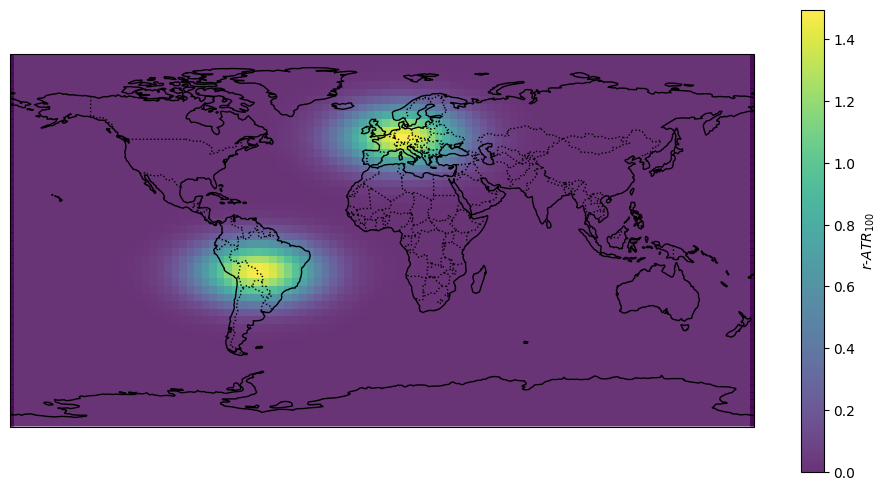

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Créer une grille de latitude et longitude
lon = np.linspace(-180, 180, 100)
lat = np.linspace(-90, 90, 50)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Exemple de données de heatmap (valeurs aléatoires ici)
def gaussian_2d(lon0, lat0, lon_grid, lat_grid, sigma_lon=20, sigma_lat=10):
    return np.exp(-(((lon_grid - lon0)**2) / (2 * sigma_lon**2) +
                    ((lat_grid - lat0)**2) / (2 * sigma_lat**2)))

# Centres des régions avec intensité
europe = gaussian_2d(lon0=10, lat0=50, lon_grid=lon_grid, lat_grid=lat_grid)  # Europe (ex: Allemagne)
south_america = gaussian_2d(lon0=-60, lat0=-15, lon_grid=lon_grid, lat_grid=lat_grid)  # Brésil

# Combinaison des deux
data = 1.5 * europe + 1.5 * south_america  # pondération possible


# Création de la figure avec projection
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Tracer la heatmap
heatmap = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap='viridis', alpha=0.8)

# Ajouter les éléments géographiques
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()

# Ajouter une grille
#ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Ajouter la barre de couleur
plt.colorbar(heatmap, orientation='vertical', pad=0.05, label=r'$r\text{-}ATR_{100}$')

# Afficher la carte
plt.savefig("map.pdf")
plt.show()